In [ ]:
!wget https://github.com/benckx/dnn-movie-posters/raw/master/data/MovieGenre.csv

--2021-01-19 11:08:40--  https://github.com/benckx/dnn-movie-posters/raw/master/data/MovieGenre.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/benckx/dnn-movie-posters/master/data/MovieGenre.csv [following]
--2021-01-19 11:08:40--  https://raw.githubusercontent.com/benckx/dnn-movie-posters/master/data/MovieGenre.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9128209 (8.7M) [text/plain]
Saving to: ‘MovieGenre.csv.2’

MovieGenre.csv.2    100%[===================>]   8.71M  --.-KB/s    in 0.1s    

2021-01-19 11:08:40 (72.6 MB/s) - ‘MovieGenre.csv.2’ saved [9128209/9128209]



# make data ready

In [ ]:
import pandas as pd
import cv2
import numpy as np
import urllib.request


df = pd.read_csv('/content/MovieGenre.csv',encoding='ISO-8859-1')
df=df.sample(frac=0.1)################## for test
def get_image(imglink):
  try:
    response = urllib.request.urlopen(imglink)
    data = response.read()
    img=cv2.imdecode(np.frombuffer(bytearray(data),dtype=np.uint8), -1)
    if img.shape ==(268,182):
      img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
  except:
    img=np.nan
  return img


df['image']=df['Poster'].apply(get_image)
clean_data = df[['image','Genre']].dropna()
clean_data['Genre'] = clean_data['Genre'].apply(lambda x: [i.strip() for i in x.split('|')])


In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer

raw_data = clean_data['image'].to_numpy()#sort_index().to_numpy()
raw_label = clean_data['Genre'].to_numpy()#sort_index().to_numpy()

data=np.stack(raw_data)
lb = MultiLabelBinarizer()
labels= lb.fit_transform(raw_label)
data.shape,labels.shape  



((3724, 268, 182, 3), (3724, 25))

### show some posters


Text(0.5, 1.0, "['Crime', 'Mystery', 'Thriller']")

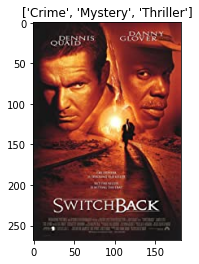

In [ ]:
import matplotlib.pyplot as plt

i=64
image = raw_data[i]
# image[:, :,[2, 0]] = image[ :,:,[0, 2]] 
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.title(raw_label[i])

# CNN Models

In [ ]:
# import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split
# from tqdm import tqdm

numOfGenre=labels.shape[1]
SIZE_x=268
SIZE_y=182 
IMG_SHAPE = (SIZE_x,SIZE_y,3)
x = data
y = labels


X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=20, test_size=0.3)


In [ ]:
#metrics 
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## simple model

In [ ]:


model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(SIZE_x,SIZE_y,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(numOfGenre, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), f1_score])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 264, 178, 16)      1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 264, 178, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 132, 89, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 132, 89, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 85, 32)       12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 42, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 42, 32)        1

In [ ]:
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test), batch_size=128)

Epoch 1/10
21/21 [==============================] - 10s 297ms/step - loss: 0.8357 - accuracy: 0.0529 - recall: 0.3821 - precision: 0.0909 - f1_score: 0.1474 - val_loss: 0.4674 - val_accuracy: 0.1494 - val_recall: 0.2631 - val_precision: 0.1594 - val_f1_score: 0.1990
Epoch 2/10
21/21 [==============================] - 5s 222ms/step - loss: 0.4842 - accuracy: 0.0834 - recall: 0.2268 - precision: 0.1322 - f1_score: 0.1671 - val_loss: 0.3118 - val_accuracy: 0.1771 - val_recall: 0.1611 - val_precision: 0.3076 - val_f1_score: 0.2119
Epoch 3/10
21/21 [==============================] - 5s 222ms/step - loss: 0.3892 - accuracy: 0.1253 - recall: 0.1944 - precision: 0.1917 - f1_score: 0.1928 - val_loss: 0.3600 - val_accuracy: 0.2630 - val_recall: 0.1504 - val_precision: 0.3415 - val_f1_score: 0.2087
Epoch 4/10
21/21 [==============================] - 5s 221ms/step - loss: 0.3549 - accuracy: 0.1561 - recall: 0.1992 - precision: 0.2385 - f1_score: 0.2166 - val_loss: 0.3156 - val_accuracy: 0.2746 - v

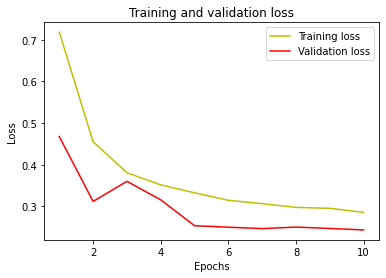

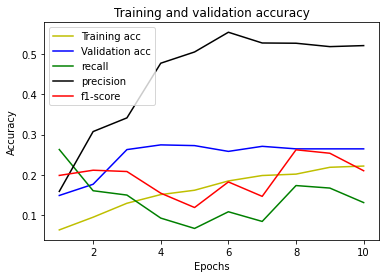

In [ ]:
import matplotlib.pyplot as plt

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_acc = history.history['val_accuracy']
val_f1_score = history.history['val_f1_score']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, val_recall, 'g', label='recall')
plt.plot(epochs, val_precision, 'black', label='precision')
plt.plot(epochs, val_f1_score, 'r', label='f1-score')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
#TEST
result = model.evaluate(X_test, Y_test)
print(result)
print("Accuracy = ", (result[1] * 100.0), "%")
print("recall = ", (result[2] * 100.0), "%")
print("precision = ", (result[3] * 100.0), "%")
print("F1-score = ", (result[4] * 100.0), "%")

35/35 [==============================] - 1s 21ms/step - loss: 0.2434 - accuracy: 0.2648 - recall: 0.1318 - precision: 0.5204 - f1_score: 0.2100
[0.243405282497406, 0.26475849747657776, 0.1317637413740158, 0.5203915238380432, 0.21001538634300232]
Accuracy =  26.475849747657776 %
recall =  13.17637413740158 %
precision =  52.03915238380432 %
F1-score =  21.001538634300232 %


## mobileNet model 
I am trying use mobileNet CNN for multi-label 


In [ ]:
#mobileNet model for multi-label poster classification
#data size should be one of square shapes in [96, 128, 160, 192, 224], but it would handel it self if you pass another shape. 



base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


model2 = Sequential()
model2.add(base_model)
# model2.add(MaxPooling2D(pool_size=(2, 2)))
# model2.add(BatchNormalization())
# model2.add(Dropout(0.1))
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
# model2.add(Dense(64, activation='relu'))
# model2.add(Dropout(0.1))
model2.add(Dense(numOfGenre, activation='sigmoid'))
model2.summary()

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), f1_score])



9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 9, 6, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 69120)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               35389952  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
___________________________________________________________

In [ ]:
history2 = model2.fit(X_train, Y_train, epochs=5, validation_data=(X_test, Y_test), batch_size=128)

Epoch 1/5
21/21 [==============================] - 18s 855ms/step - loss: 0.1976 - accuracy: 0.4249 - recall: 0.3665 - precision: 0.6856 - f1_score: 0.4776 - val_loss: 6.1216 - val_accuracy: 0.2448 - val_recall: 0.2278 - val_precision: 0.4982 - val_f1_score: 0.3107
Epoch 2/5
21/21 [==============================] - 19s 893ms/step - loss: 0.1898 - accuracy: 0.4288 - recall: 0.4020 - precision: 0.7148 - f1_score: 0.5125 - val_loss: 4.6984 - val_accuracy: 0.2448 - val_recall: 0.3299 - val_precision: 0.4072 - val_f1_score: 0.3630
Epoch 3/5
21/21 [==============================] - 18s 863ms/step - loss: 0.1837 - accuracy: 0.4550 - recall: 0.4282 - precision: 0.7225 - f1_score: 0.5395 - val_loss: 6.4848 - val_accuracy: 0.2448 - val_recall: 0.2278 - val_precision: 0.4977 - val_f1_score: 0.3106
Epoch 4/5
21/21 [==============================] - 18s 856ms/step - loss: 0.1703 - accuracy: 0.4770 - recall: 0.4735 - precision: 0.7440 - f1_score: 0.5803 - val_loss: 5.1702 - val_accuracy: 0.2448 - va

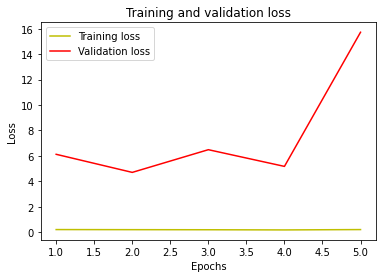

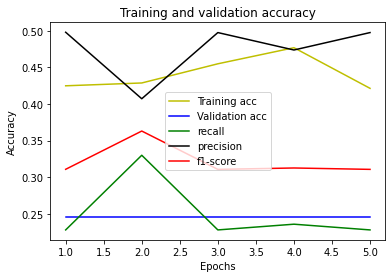

In [ ]:
import matplotlib.pyplot as plt

#plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history2.history['accuracy']
val_precision = history2.history['val_precision']
val_recall = history2.history['val_recall']
val_acc = history2.history['val_accuracy']
val_f1_score = history2.history['val_f1_score']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, val_recall, 'g', label='recall')
plt.plot(epochs, val_precision, 'black', label='precision')
plt.plot(epochs, val_f1_score, 'r', label='f1-score')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#TEST
result = model2.evaluate(X_test, Y_test)
print(result)
print("Accuracy = ", (result[1] * 100.0), "%")
print("recall = ", (result[2] * 100.0), "%")
print("precision = ", (result[3] * 100.0), "%")
print("F1-score = ", (result[4] * 100.0), "%")

35/35 [==============================] - 1s 41ms/step - loss: 15.7292 - accuracy: 0.2448 - recall: 0.2278 - precision: 0.4977 - f1_score: 0.3129
[15.729162216186523, 0.24482448399066925, 0.2277594655752182, 0.49774977564811707, 0.31289079785346985]
Accuracy =  24.482448399066925 %
recall =  22.77594655752182 %
precision =  49.77497756481171 %
F1-score =  31.289079785346985 %


## VGG19


In [ ]:
from tensorflow.keras.applications import VGG19


base_model = VGG19(
    include_top=False,
    input_shape=IMG_SHAPE)  # input_tensor=None,    # pooling=None,    # classes=1000,    # classifier_activation="softmax"


model = Sequential()
model.add(base_model)
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(numOfGenre, activation='sigmoid'))

model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), f1_score])

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 5, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5243136   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________

In [ ]:
history = model.fit(X_train, Y_train, epochs=12, validation_data=(X_test, Y_test), batch_size=128)


Epoch 1/12
11/11 [==============================] - 34s 2s/step - loss: 8.2346 - accuracy: 0.0284 - val_loss: 0.4980 - val_accuracy: 0.0340
Epoch 2/12
11/11 [==============================] - 22s 2s/step - loss: 0.4772 - accuracy: 0.0291 - val_loss: 0.3803 - val_accuracy: 0.0680
Epoch 3/12
11/11 [==============================] - 22s 2s/step - loss: 0.4323 - accuracy: 0.0383 - val_loss: 0.3278 - val_accuracy: 0.0680
Epoch 4/12
11/11 [==============================] - 21s 2s/step - loss: 0.3982 - accuracy: 0.0491 - val_loss: 0.3024 - val_accuracy: 0.0733
Epoch 5/12
11/11 [==============================] - 21s 2s/step - loss: 0.3687 - accuracy: 0.0767 - val_loss: 0.2742 - val_accuracy: 0.2719
Epoch 6/12
11/11 [==============================] - 21s 2s/step - loss: 0.3445 - accuracy: 0.1204 - val_loss: 0.2634 - val_accuracy: 0.2737
Epoch 7/12
11/11 [==============================] - 21s 2s/step - loss: 0.3286 - accuracy: 0.1541 - val_loss: 0.2494 - val_accuracy: 0.2737
Epoch 8/12
11/11 [==

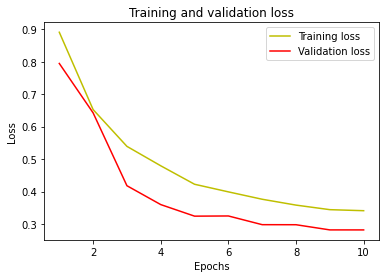

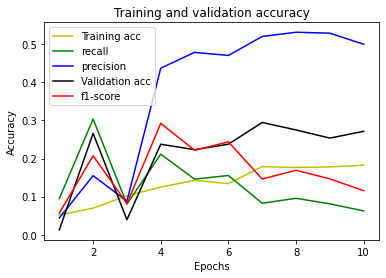

In [ ]:
import matplotlib.pyplot as plt

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_acc = history.history['val_accuracy']
val_f1_score = history.history['val_f1_score']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, val_recall, 'g', label='recall')
plt.plot(epochs, val_precision, 'black', label='precision')
plt.plot(epochs, val_f1_score, 'r', label='f1-score')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#TEST
result = model.evaluate(X_test, Y_test)
print(result)
print("Accuracy = ", (result[1] * 100.0), "%")
print("recall = ", (result[2] * 100.0), "%")
print("precision = ", (result[3] * 100.0), "%")
print("F1-score = ", (result[4] * 100.0), "%")

18/18 [==============================] - 0s 10ms/step - loss: 0.2818 - accuracy: 0.2714 - recall: 0.0623 - precision: 0.5000 - f1_score: 0.1081
[0.2817705571651459, 0.27142858505249023, 0.06234817951917648, 0.5, 0.10814505070447922]
Accuracy =  27.142858505249023 %
recall =  6.234817951917648 %
precision =  50.0 %
F1-score =  10.814505070447922 %


## ResNetv2


In [ ]:
from tensorflow.keras.applications import ResNet152V2


base_model = ResNet152V2(
    include_top=False,
    input_shape=IMG_SHAPE)  # input_tensor=None,    # pooling=None,    # classes=1000,    # classifier_activation="softmax"


model = Sequential()
model.add(base_model)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(numOfGenre, activation='sigmoid'))

model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), f1_score])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 9, 6, 2048)        58331648  
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 3, 2048)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 3, 2048)        8192      
_________________________________________________________________
flatten_1 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6291712   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [ ]:
history = model.fit(X_train, Y_train, epochs=8, validation_data=(X_test, Y_test), batch_size=32)


Epoch 1/8


ResourceExhaustedError: ignored

In [ ]:
import matplotlib.pyplot as plt

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_acc = history.history['val_accuracy']
val_f1_score = history.history['val_f1_score']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, val_recall, 'g', label='recall')
plt.plot(epochs, val_precision, 'black', label='precision')
plt.plot(epochs, val_f1_score, 'r', label='f1-score')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#TEST
result = model.evaluate(X_test, Y_test)
print(result)
print("Accuracy = ", (result[1] * 100.0), "%")
print("recall = ", (result[2] * 100.0), "%")
print("precision = ", (result[3] * 100.0), "%")
print("F1-score = ", (result[4] * 100.0), "%")

## test both models on an image

In [ ]:
#Validate on an image
img= raw_data[8]
SIZE = 200
# img = image.load_img('ddlj.jpg', target_size=(SIZE,SIZE,3))
from keras.preprocessing import image
# img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

proba2 = model2.predict(img)  #Get probabilities for each class
proba = model.predict(img)
sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories
sorted_categories2 = np.argsort(proba2[0])[:-11:-1]  #Get class names for top 10 categories

print("model1", proba)
print(sorted_categories)
print("model2 (mobilenet)", proba2)
print(sorted_categories2)


